In [2]:
import re
import numpy as np
np.set_printoptions(threshold=np.inf)

# function to split a line into objects by whitespaces
def ws_split(lst):
    lst = re.split(r'\s+', lst)
    lst.pop()        #remove first empty character
    lst.pop(0)       #remove last empty character
    return lst

def ws_split_int(lst):
    lst = re.split(r'\s+', lst)
    lst.pop()        #remove first empty character
    lst.pop(0)       #remove last empty character
    lst = [int(x) for x in lst]
    return lst

def instance_read(instance):
    with open(instance) as f:
        lines = f.readlines()
    d = dict();
    d['ref'] = lines[0]
    num_of_vars = d['num_of_vars'] = int(lines[1])
    d['profits'] = np.asarray(ws_split_int(lines[2]))
    combinations = [ws_split_int(i) for i in lines[3:num_of_vars+2]]
    combi_length = max(map(len, combinations))
    d['combinations'] = np.array([[0]*(combi_length-len(xi))+xi for xi in combinations])
    d['constraint_type'] = lines[int(num_of_vars)+3]
    weights = np.asarray(ws_split_int(lines[num_of_vars+5]))
    d['weights'] = weights
    
    d['capacity'] = 0.8 * sum(weights)
        
    return d


####
# available keys: ref (instance reference) 
# num_of_vars (n)
# profits (p_i)
# combinations (p_ij)
# constraint_type
# capacity (C_k)
# weights (w_i)
####
num_kp = 3

instance = instance_read('jeu_100_25_1.txt')
num_of_vars = instance.get("num_of_vars")
profits = instance.get("profits")
combinations = instance.get("combinations")
constraint_type = instance.get("constraint_type")
capacity = instance.get("capacity") / num_kp
weights = instance.get("weights")

ou will use ALL the data sets foundherehttps://cedric.cnam.fr/~soutif/QKP/QKP.htmlin your analysis with the modi cation that thenumber of knapsacksM23;5;10 and for each problem instance the capacity of each knapsack is set to80% of the sum of all item weights divided by the number of knapsack

gen	nevals	max    	avg    
0  	50    	31885.5	9683.65
1  	50    	31885.5	10601.3
2  	50    	32677.5	11264.9
3  	50    	32677.5	11314.5
4  	50    	33513.3	10741.9
5  	50    	33513.3	10593  
6  	50    	33513.3	11764  
7  	50    	35085.4	12336.6
8  	50    	36852  	11927.6
9  	50    	36852  	12029.9
10 	50    	36852  	12079  
11 	50    	36852  	11828.4
12 	50    	36852  	11874.9
13 	50    	36852  	12042.1
14 	50    	36852  	12371.2
15 	50    	36852  	12761.3
16 	50    	36852  	12892.2
17 	50    	39165.2	13048.7
18 	50    	39422.2	12710  
19 	50    	39422.2	12573.6
20 	50    	39422.2	12680.7
21 	50    	39422.2	12574.7
22 	50    	39422.2	12921.4
23 	50    	39422.2	12710.1
24 	50    	39933.4	12481.2
25 	50    	39933.4	12758.5
26 	50    	40388  	12398.5
27 	50    	40388  	12554.5
28 	50    	40600  	12575.9
29 	50    	40600  	12216.6
30 	50    	40600  	13287.3
31 	50    	40600  	14191.5
32 	50    	40600  	14240.3
33 	50    	40600  	14023.7
34 	50    	40600  	14460.7
35 	50    	40600  	14303.7
3

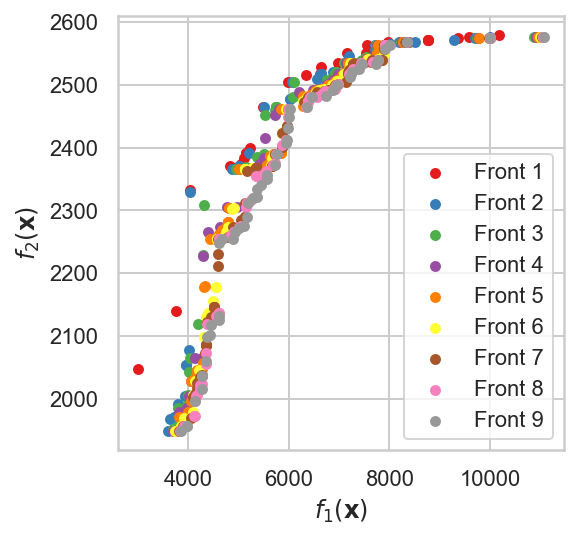

In [113]:
import math
import time, array, random, copy, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deap import algorithms, base, benchmarks, tools, creator

def instance_create(instance, m, pop_size, num_gen, mut_rate, xover_rate):
    with open(instance) as f:
        lines = f.readlines()
    d = dict();
    d['ref'] = lines[0]
    num_of_vars = d['num_of_vars'] = int(lines[1])
    d['profits'] = np.asarray(ws_split_int(lines[2]))
    combinations = [ws_split_int(i) for i in lines[3:num_of_vars+2]]
    combi_length = max(map(len, combinations))
    d['combinations'] = np.array([[0]*(combi_length-len(xi))+xi for xi in combinations])
    d['constraint_type'] = lines[int(num_of_vars)+3]
    weights = np.asarray(ws_split_int(lines[num_of_vars+5]))
    d['weights'] = weights    
    d['capacity'] = math.floor((0.8 * sum(weights)) / m)
    d['mut_rate'] = mut_rate
    d['xover_rate'] = xover_rate
    d['num_gen'] = num_gen
    d['pop_size'] = pop_size
    d['n_kp'] = m
    return d
def mutation(x, instance):
    if instance == None:
        raise ValueError("No Instance Passed into Mutation Function")
    n = len(x)
    m = int(instance.get("n_kp"))
    index = random.randrange(0,n)
    var = random.randint(0,m)
    x[index] = var
    return x, 
def uniform(low, m, n_kp):
    n = []
    for i in range(0,m):
        n.append(random.randint(0,n_kp))
    return n
def eval_fitness(individual, instance):
    #global instance
    m = max(individual)
    num_of_vars = instance.get("num_of_vars")
    profits = instance.get("profits")
    combinations = instance.get("combinations")
    constraint_type = instance.get("constraint_type")
    capacity = int(instance.get("capacity"))
    weights = instance.get("weights")
    knapsacks_weight = [0]*m
    knapsacks_profit = [0]*m

    for i in range(len(individual)):
        if individual[i] != 0:
            knapsacks_weight[individual[i]-1] += weights[i]
            knapsacks_profit[individual[i]-1] += profits[i]
            for j in range(len(individual)):
                if individual[i] == individual[j]:
                    knapsacks_profit[individual[i]-1] += combinations[i-1][j-1]
    f1 = 0
    f2 = sum(knapsacks_weight)
    f3 = min(knapsacks_profit)

    for i in range(m):
        if knapsacks_weight[i] > capacity:
            f1 += knapsacks_profit[i] * (capacity / knapsacks_weight[i])
        else:
            f1 += knapsacks_profit[i]
    f1 += m * min(knapsacks_profit)
    return f1, f2, f3
def favorite_child_xover(ind1, ind2):
    fit1 = ind1.fitness.values
    fit2 = ind2.fitness.values

    prob = fit1[0] / (fit1[0]+fit2[0])

    if fit1[0] > fit2[0]:
        prob = 1/prob

    size = min(len(ind1), len(ind2))

    for i in range(size):
        if random.random() > prob:
            ind1[i] = ind2[i]
            ind2[i] = ind1[i]
    return ind1, ind2
def run_ea(toolbox, stats=None, verbose=False):
    pop = toolbox.population(n=toolbox.pop_size)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("avg", np.mean)
    population, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=toolbox.pop_size, 
                                     lambda_=toolbox.pop_size, 
                                     cxpb=1-toolbox.mut_prob,
                                     mutpb=toolbox.mut_prob, 
                                     stats=stats, 
                                     ngen=toolbox.max_gen, 
                                     verbose=True)
    return population, logbook
def ea_execution(instance):
    ## Set up problem
    creator.create("FitnessMin", base.Fitness, weights=(1.0,-1.0, 1.0))
    creator.create("Individual", list, typecode='i', fitness=creator.FitnessMin)
    ## Register Functions and Create Toolbox
    toolbox = base.Toolbox()
    ## General parameters
    toolbox.max_gen = instance.get("num_gen")
    toolbox.mut_prob = instance.get("mut_rate")
    toolbox.cx_prob = instance.get("xover_rate")
    ## Generating Population
    toolbox.pop_size = instance.get('pop_size')    
    toolbox.register("attr_float", uniform, 0, instance.get("num_of_vars"), num_kp)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    ## Evaluating Fitness
    toolbox.register("evaluate", lambda x: eval_fitness(x, instance))
    ## Mutation
    toolbox.register("mutate", lambda x: mutation(x, instance))
    ## Xover
    toolbox.register("mate", favorite_child_xover)
    ## Selection
    toolbox.register("select", tools.selNSGA2)
    %time res,_ = run_ea(toolbox)
    fronts = tools.emo.sortLogNondominated(res, len(res))
    plot_colors = seaborn.color_palette("Set1", n_colors=10)
    fig, ax = plt.subplots(1, figsize=(4,4))
    for i,inds in enumerate(fronts):
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)
        df.plot(ax=ax, kind='scatter', label='Front ' + str(i+1), 
                     x=df.columns[0], y=df.columns[1], 
                     color=plot_colors[i])
    plt.xlabel('$f_1(\mathbf{x})$');plt.ylabel('$f_2(\mathbf{x})$');

instance = instance_create('jeu_100_25_1.txt', 3, 50, 50, .05, .8)
ea_execution(instance)

gen	nevals	max  	avg    
0  	500   	36755	12852.8
1  	500   	36755	10571.3
2  	500   	36755	9431.17
3  	500   	35979	8525.48
4  	500   	35979	7755.18
5  	500   	31432.8	7611.44
6  	500   	26857.7	7391.09
7  	500   	16656.5	7215.92
8  	500   	16766.4	7104.2 
9  	500   	16367  	7085.23
10 	500   	16966  	6880.12
11 	500   	24290  	6897.64
12 	500   	17433.6	6776.62
13 	500   	17758.8	6806.83
14 	500   	16748.9	6772.13
15 	500   	16748.9	6609.16
16 	500   	16748.9	6466.35
17 	500   	16748.9	6483.17
18 	500   	15761.4	6488.35
19 	500   	15692.2	6534.45
20 	500   	15331.9	6443.87
21 	500   	15197.9	6256.31
22 	500   	14945.4	6215.17
23 	500   	14945.4	6038.1 
24 	500   	14945.4	5885.05
25 	500   	14945.4	5971.95
26 	500   	14945.4	5928.49
27 	500   	14945.4	5884.13
28 	500   	14681.9	5814.41
29 	500   	14468.9	5734.39
30 	500   	14468.9	5474.83
31 	500   	14468.9	5440.38
32 	500   	14468.9	5492.57
33 	500   	16346.8	5522.77
34 	500   	14582.9	5658.62
35 	500   	14582.9	5444.01
36 	500   	14

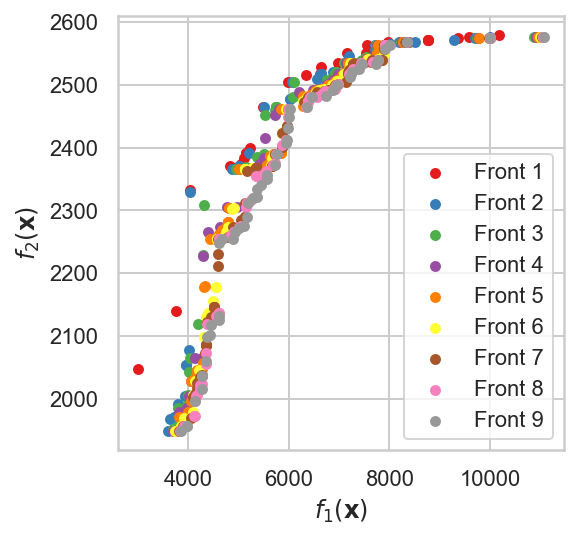

In [107]:
import time, array, random, copy, math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn
seaborn.set(style='whitegrid')
seaborn.set_context('notebook')

from deap import algorithms, base, benchmarks, tools, creator


def eval_fitness(individual):
    global instance
    m = max(individual)
    
    num_of_vars = instance.get("num_of_vars")
    profits = instance.get("profits")
    combinations = instance.get("combinations")
    constraint_type = instance.get("constraint_type")
    capacity = int(instance.get("capacity"))
    weights = instance.get("weights")
    knapsacks_weight = [0]*m
    knapsacks_profit = [0]*m
    
    for i in range(len(individual)):
        if individual[i] != 0:
            knapsacks_weight[individual[i]-1] += weights[i]
            knapsacks_profit[individual[i]-1] += profits[i]
            for j in range(len(individual)):
                if individual[i] == individual[j]:
                    knapsacks_profit[individual[i]-1] += combinations[i-1][j-1]
    f1 = 0
    f2 = sum(knapsacks_weight)

    for i in range(m):
        if knapsacks_weight[i] > capacity:
            f1 += knapsacks_profit[i] * (capacity / knapsacks_weight[i])
        else:
            f1 += knapsacks_profit[i]
    f1 += m * min(knapsacks_profit)
    return f1, f2

def uniform(low, m, n_kp):
    n = []
    for i in range(0,m):
        n.append(random.randint(0,n_kp))
    return n

def favorite_child_xover(ind1, ind2):
    fit1 = ind1.fitness.values
    fit2 = ind2.fitness.values
    
    prob = fit1[0] / (fit1[0]+fit2[0])
    
    if fit1[0] > fit2[0]:
        prob = 1/prob
    
    size = min(len(ind1), len(ind2))
    
    for i in range(size):
        if random.random() > prob:
            ind1[i] = ind2[i]
            ind2[i] = ind1[i]
    return ind1, ind2

def mutation(x):
    index = random.randrange(len(x))
    var = random.randint(0,len(x))
    x[index] = var
    return x,

creator.create("FitnessMin", base.Fitness, weights=(-1.0,1.0))
creator.create("Individual", list, typecode='i', 
               fitness=creator.FitnessMin)

toolbox = base.Toolbox()


BOUND_LOW, BOUND_UP = 0, instance.get("num_of_vars")
NDIM = 2
toolbox.register("evaluate", eval_fitness)

toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, num_kp)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
#toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mate", favorite_child_xover)
#toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)
toolbox.register("mutate", mutation,)
toolbox.register("select", tools.selNSGA2)

toolbox.pop_size = 500
toolbox.max_gen = 50
toolbox.mut_prob = 0.5

def run_ea(toolbox, stats=None, verbose=False):
    pop = toolbox.population(n=toolbox.pop_size)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("avg", np.mean)
    population, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=toolbox.pop_size, 
                                     lambda_=toolbox.pop_size, 
                                     cxpb=1-toolbox.mut_prob,
                                     mutpb=toolbox.mut_prob, 
                                     stats=stats, 
                                     ngen=toolbox.max_gen, 
                                     verbose=True)
    return population, logbook

%time res,_ = run_ea(toolbox)

fronts = tools.emo.sortLogNondominated(res, len(res))

plot_colors = seaborn.color_palette("Set1", n_colors=10)
fig, ax = plt.subplots(1, figsize=(4,4))
for i,inds in enumerate(fronts):
    par = [toolbox.evaluate(ind) for ind in inds]
    df = pd.DataFrame(par)
    df.plot(ax=ax, kind='scatter', label='Front ' + str(i+1), 
                 x=df.columns[0], y=df.columns[1], 
                 color=plot_colors[i])
plt.xlabel('$f_1(\mathbf{x})$');plt.ylabel('$f_2(\mathbf{x})$');

In [70]:
import random
individual = []
m = random.randint(1,num_of_vars)            #number of knapsacks

for i in range(0,num_of_vars):
    n = random.randint(0,m)
    individual.append(n)

knapsack_capacity = capacity
def feature_transform(integer_representation):
    n = len(integer_representation)
    m = max(integer_representation)
    if min(integer_representation) < 0:
        raise ValueError("One of the items is in a negative knapsack, which doesn't make sense")
    binary_matrix = np.zeros((m,n))
    for i in range(n):
        if not integer_representation[i] == 0:
            binary_matrix[integer_representation[i]-1, i] = 1
    idx = np.argwhere(np.all(binary_matrix[..., :] == 0, axis=1))
    a2 = np.delete(binary_matrix, idx, axis=0)
    return feature_revert(a2)
def feature_revert(binary_matrix):
    n = binary_matrix.shape[1]
    m = binary_matrix.shape[0]
    sol = [0] * binary_matrix.shape[1]
    result = (binary_matrix.T @ np.arange(1,m+1)).astype(int)
    return result.tolist()
def fitness_eval(individual, instance):
    individual = feature_transform(individual)
    m = int(max(individual))
    num_of_vars = instance.get("num_of_vars")
    profits = instance.get("profits")
    combinations = instance.get("combinations")
    constraint_type = instance.get("constraint_type")
    capacity = int(instance.get("capacity"))
    weights = instance.get("weights")
    knapsacks_weight = [0]*m
    knapsacks_profit = [0]*m
    for i in range(len(individual)):
        if individual[i] != 0:
            knapsacks_weight[individual[i]-1] += weights[i]
            knapsacks_profit[individual[i]-1] += profits[i]
            for j in range(len(individual)):
                if individual[i] == individual[j]:
                    knapsacks_profit[individual[i]-1] += combinations[i-1][j-1]
    f1 = 0
    f2 = sum(knapsacks_weight)
    for i in range(m):
        if knapsacks_weight[i] > capacity:
            f1 += knapsacks_profit[i] * (capacity / knapsacks_weights[i])
        else:
            f1+= knapsacks_profit[i]
    f1 += m * min(knapsacks_profit)
    return f1, f2
fitness_eval(individual, instance)

### Command for adding fitness function:
## toolbox.register("evaluate", lambda x: fitness_eval(x, instance))


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


(9919, 2366)

In [1]:
import time, array, random, copy, math
import numpy as np
import pandas as pd
from random import sample

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn
seaborn.set(style='whitegrid')
seaborn.set_context('notebook')

from deap import algorithms, base, benchmarks, tools, creator

random.seed(a=42)

creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))
creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMin)

def dent(individual, lbda = 0.85):
    """ 
    Implements the test problem Dent
    Num. variables = 2; bounds in [-1.5, 1.5]; num. objetives = 2.
    @author Cesar Revelo
    """
    d  = lbda * math.exp(-(individual[0] - individual[1]) ** 2)  
    f1 = 0.5 * (math.sqrt(1 + (individual[0] + individual[1]) ** 2) + \
                math.sqrt(1 + (individual[0] - individual[1]) ** 2) + \
                individual[0] - individual[1]) + d
    f2 = 0.5 * (math.sqrt(1 + (individual[0] + individual[1]) ** 2) + \
                math.sqrt(1 + (individual[0] - individual[1]) ** 2) - \
                individual[0] + individual[1]) + d
    return f1, f2

toolbox = base.Toolbox()

BOUND_LOW, BOUND_UP = 0, 100
NDIM = 2
toolbox.register("evaluate", dent)

def uniform(low, up, size=None):
    try:
        return sample([*range(low, up+1, 1)], k=up)
    except TypeError:
        return [sample([*range(a, b+1, 1)], k=up) for a, b in zip([low] * size, [up] * size)]

toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

num_samples = 50
limits = [np.arange(BOUND_LOW, BOUND_UP, (BOUND_UP - BOUND_LOW)/num_samples)] * NDIM
sample_x = np.meshgrid(*limits)

flat = []
for i in range(len(sample_x)):
    x_i = sample_x[i]
    flat.append(x_i.reshape(num_samples**NDIM))
    
example_pop = toolbox.population(n=num_samples**NDIM)

for i, ind in enumerate(example_pop):
    for j in range(len(flat)):
        ind[j] = flat[j][i]
        
fitnesses = toolbox.map(toolbox.evaluate, example_pop)
for ind, fit in zip(example_pop, fitnesses):
    ind.fitness.values = fit

def pareto_dominance(x,y):
    return tools.emo.isDominated(x.fitness.values, y.fitness.values)

dominated = [ind for ind in example_pop if pareto_dominance(a_given_individual, ind)]
dominators = [ind for ind in example_pop if pareto_dominance(ind, a_given_individual)]
others = [ind for ind in example_pop if not ind in dominated and not ind in dominators]

def plot_dent():
    'Plots the points in decision and objective spaces.'
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    for ind in dominators: plt.plot(ind[0], ind[1], 'r.')
    for ind in dominated: plt.plot(ind[0], ind[1], 'g.')
    for ind in others: plt.plot(ind[0], ind[1], 'k.', ms=3)
    plt.plot(a_given_individual[0], a_given_individual[1], 'bo', ms=6);
    plt.xlabel('$x_1$');plt.ylabel('$x_2$');
    plt.title('Decision space');
    plt.subplot(1,2,2)
    for ind in dominators: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'r.', alpha=0.7)
    for ind in dominated: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'g.', alpha=0.7)
    for ind in others: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', alpha=0.7, ms=3)
    plt.plot(a_given_individual.fitness.values[0], a_given_individual.fitness.values[1], 'bo', ms=6);
    plt.xlabel('$f_1(\mathbf{x})$');plt.ylabel('$f_2(\mathbf{x})$');
    plt.xlim((0.5,3.6));plt.ylim((0.5,3.6));
    plt.title('Objective space');
    plt.tight_layout()
    
plot_dent()

non_dom = tools.sortNondominated(example_pop, k=len(example_pop), first_front_only=True)[0]

plt.figure(figsize=(5,5))
for ind in example_pop:
    plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', ms=3, alpha=0.5)
for ind in non_dom:
    plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'bo', alpha=0.74, ms=5)
plt.title('Pareto-optimal front')



NameError: name 'a_given_individual' is not defined